# TP : Conception d'Algorithmes Génétiques avec GeneticSharp

## Objectif
Dans ce TP, nous allons concevoir un filtre de détection de bords en utilisant la bibliothèque **GeneticSharp**. Nous chercherons à approximer un filtre de convolution de référence en évoluant une population de filtres grâce à un algorithme génétique.

---


In [1]:
// Dépendances nécessaires
#r "nuget: GeneticSharp, 3.1.4"
#r "nuget: System.Drawing.Common, 9.0.0"

#r "nuget: Emgu.CV, 4.9.0.5494"
#r "nuget: Emgu.CV.Bitmap, 4.9.0.5494"
#r "nuget: Emgu.CV.runtime.mini.windows, 4.9.0.5494"

#r "nuget: SkiaSharp, 2.88.3"

#load "../Config/SkiaUtils.cs"


Installed Packages Emgu.CV, 4.9.0.5494 Emgu.CV.Bitmap, 4.9.0.5494 Emgu.CV.runtime.mini.windows, 4.9.0.5494 GeneticSharp, 3.1.4 SkiaSharp, 2.88.3 System.Drawing.Common, 9.0.0

In [ ]:
// Imports
using System;
using System.IO;
using System.Drawing;
using Microsoft.DotNet.Interactive;

using System.Diagnostics;
using System.Globalization;

using GeneticSharp;

using Emgu.CV;
using Emgu.CV.CvEnum;
using Emgu.CV.Structure;

public static void SaveImage(Mat image, string fileName)
{
    image.Save(fileName);
    Console.WriteLine($"Image enregistrée : {fileName}");
}

Console.WriteLine("Dépendances chargées.");

Dépendances chargées.


## Étape 1 : Définir le Chromosome

Nous allons implémenter un chromosome pour représenter les filtres par convolution. Chaque chromosome contiendra des gènes, qui sont des matrices symétriques. Ces matrices seront sommées pour produire le filtre final.

---


In [2]:
// Représentation du filtre par convolution sous forme de chromosome
public class EdgeChromosome : ChromosomeBase
{
    private const int KernelSize = 7; // Taille de la matrice du noyau

    public EdgeChromosome(int length) : base(length)
    {
        // Initialisation des gènes
        for (int i = 0; i < Length; i++)
        {
            ReplaceGene(i, GenerateGene(i));
        }
    }

    // Création d'un nouveau chromosome pour la population
    public override IChromosome CreateNew()
    {
        return new EdgeChromosome(Length);
    }

    // Génération d'un gène contenant une matrice avec des perturbations asymétriques
    public override Gene GenerateGene(int geneIndex)
    {
        var rnd = RandomizationProvider.Current;
        var matrix = new int[KernelSize, KernelSize];

        for (int i = 0; i < KernelSize; i++)
        {
            for (int j = 0; j < KernelSize; j++)
            {
                matrix[i, j] = rnd.GetInt(-20, 20);
               
            }
        }
        return new Gene(matrix);
    }

    public int[,] GetCompleteMatrix()
{
    var completeMatrix = new int[KernelSize, KernelSize];

    // Ajouter les matrices des gènes
    foreach (var gene in GetGenes())
    {
        var matrix = (int[,])gene.Value;
        for (int i = 0; i < KernelSize; i++)
        {
            for (int j = 0; j < KernelSize; j++)
            {
                completeMatrix[i, j] += matrix[i, j];
            }
        }
    }

    // Normalisation dynamique si des valeurs extrêmes apparaissent
    int maxAbsValue = completeMatrix.Cast<int>().Select(Math.Abs).Max();
    if (maxAbsValue > 10) // Seulement si les valeurs dépassent un seuil
    {
        for (int i = 0; i < KernelSize; i++)
        {
            for (int j = 0; j < KernelSize; j++)
            {
                completeMatrix[i, j] = (int)(10.0 * completeMatrix[i, j] / maxAbsValue);
            }
        }
    }

    return completeMatrix;
}

}
Console.WriteLine("Chromosome défini.");


Chromosome défini.


Testons la création d'un chromosome, ses gènes, et la matrice résultante correspondante

In [ ]:
var testChromosome = new EdgeChromosome(5); // 5 gènes
Console.WriteLine("Gènes générés :");
foreach (var gene in testChromosome.GetGenes())
{
    var matrix = (int[,])gene.Value;
    for (int i = 0; i < matrix.GetLength(0); i++)
    {
        for (int j = 0; j < matrix.GetLength(1); j++)
        {
            Console.Write($"{matrix[i, j]} ");
        }
        Console.WriteLine();
    }
    Console.WriteLine();
}

var testMatrix = testChromosome.GetCompleteMatrix();

Console.WriteLine("Matrice complète générée :");
for (int i = 0; i < testMatrix.GetLength(0); i++)
{
    for (int j = 0; j < testMatrix.GetLength(1); j++)
    {
        Console.Write($"{testMatrix[i, j]} ");
    }
    Console.WriteLine();
}


Gènes générés :
11 -8 -12 2 -6 16 11 
7 -10 -18 -5 -12 3 18 
-13 0 2 0 16 -10 10 
-11 -16 -10 17 -12 -1 15 
-3 -12 -20 11 2 -18 10 
8 9 -13 -5 8 -20 -8 
16 11 -7 7 -2 -13 -17 

7 18 16 -5 15 3 10 
6 19 -5 -20 7 15 -16 
1 -16 17 1 -7 8 16 
-2 0 3 -15 12 -1 4 
4 -10 1 -14 -2 -15 -3 
15 7 -11 -9 0 19 13 
-6 -12 11 -4 -20 -17 -12 

19 13 -1 18 -1 -7 15 
15 -3 -19 -12 -10 2 5 
5 -20 -8 4 14 10 -14 
18 14 -18 4 16 1 -13 
-9 18 -7 -2 -9 10 -18 
-2 -6 5 3 -8 -20 3 
-18 -12 -15 18 8 5 -14 

-17 7 13 -16 -11 0 18 
-16 -9 0 -3 14 -6 7 
14 -9 -1 3 -10 -13 -9 
7 11 16 3 11 -13 15 
-19 -17 18 4 18 9 0 
0 -1 -4 -15 3 15 5 
-1 10 -7 -15 -14 -2 7 

12 -14 -9 -1 -19 4 14 
5 -6 10 3 -15 0 19 
-16 -11 16 7 -20 13 8 
-18 -3 -14 -11 -16 18 -15 
-15 10 -20 18 2 -15 -14 
-8 -17 -1 -8 4 -5 15 
-15 -2 -6 -20 -10 0 -11 

Matrice complète générée :
4 2 1 0 -3 2 10 
2 -1 -4 -5 -2 2 4 
-1 -8 3 2 -1 1 1 
0 0 -3 0 1 0 0 
-6 -1 -4 2 1 -4 -3 
1 -1 -3 -5 1 -1 4 
-3 0 -3 -2 -5 -3 -6 


## Étape 2 : Définir la Fonction d'Évaluation

Nous allons implémenter une classe qui compare les résultats des filtres générés par les chromosomes à un filtre de référence basé sur Sobel.

---


In [3]:
using Emgu.CV;
using Emgu.CV.CvEnum;
using Emgu.CV.Structure;
using System.Drawing;
using System.Runtime.InteropServices;

public class EdgeFitness : IFitness
{
    private readonly Mat _originalImage;
    private readonly Mat _referenceImage;

    public EdgeFitness(Bitmap originalImage)
    {
    _originalImage = BitmapToMat(originalImage);

    // Convertir en niveaux de gris
    if (_originalImage.NumberOfChannels > 1)
    {
        CvInvoke.CvtColor(_originalImage, _originalImage, ColorConversion.Bgr2Gray);
    }

    // Appliquer le filtre Sobel pour référence
    _referenceImage = new Mat();
    CvInvoke.Sobel(_originalImage, _referenceImage, DepthType.Cv64F, 1, 0);

    if (_referenceImage.NumberOfChannels != 1)
        {
            CvInvoke.CvtColor(_referenceImage, _referenceImage, ColorConversion.Bgr2Gray);
        }

    }


    public async Task DisplayImagesAsync()
    {
        // Afficher l'image originale
        SaveImage(_originalImage, "original.png");
        await SkiaUtils.ShowImage("original.png", _originalImage.Width, _originalImage.Height);

        // Afficher l'image de référence (filtre Sobel)
        SaveImage(_referenceImage, "reference.png");
        await SkiaUtils.ShowImage("reference.png", _referenceImage.Width, _referenceImage.Height);
    }


    

    private Mat ApplyFilter(EdgeChromosome chromosome, bool display = false)
    {
        var filterMatrix = chromosome.GetCompleteMatrix();
        var kernel = ArrayToMat(ConvertToFloat(filterMatrix));

        if (display)
        {   
            Console.WriteLine("Noyau généré :");
            for (int i = 0; i < kernel.Rows; i++)
            {
                for (int j = 0; j < kernel.Cols; j++)
                {
                    Console.Write($"{kernel.GetData().GetValue(i, j)} ");
                }
                Console.WriteLine();
            }
        }
        

        var sourceImage = _originalImage.Clone();
        if (sourceImage.Depth != DepthType.Cv32F)
        {
            sourceImage.ConvertTo(sourceImage, DepthType.Cv32F);
        }

        var filteredImage = new Mat(sourceImage.Rows, sourceImage.Cols, DepthType.Cv32F, 1);
        CvInvoke.Filter2D(sourceImage, filteredImage, kernel, new Point(-1, -1));

        // Aligner la profondeur avec _referenceImage
        if (filteredImage.Depth != _referenceImage.Depth)
        {
            filteredImage.ConvertTo(filteredImage, _referenceImage.Depth);
        }

        return filteredImage;
    }


    
    public double Evaluate(IChromosome chromosome)
{
    var filteredImage = ApplyFilter((EdgeChromosome)chromosome, false);

    // Convertir en niveaux de gris si nécessaire
    if (filteredImage.NumberOfChannels > 1)
    {
        CvInvoke.CvtColor(filteredImage, filteredImage, ColorConversion.Bgr2Gray);
    }

    if (_referenceImage.NumberOfChannels > 1)
    {
        CvInvoke.CvtColor(_referenceImage, _referenceImage, ColorConversion.Bgr2Gray);
    }

    // Assurer la même profondeur
    if (filteredImage.Depth != DepthType.Cv8U)
    {
        filteredImage.ConvertTo(filteredImage, DepthType.Cv8U);
    }

    if (_referenceImage.Depth != DepthType.Cv8U)
    {
        _referenceImage.ConvertTo(_referenceImage, DepthType.Cv8U);
    }

    // Redimensionner si nécessaire
    if (filteredImage.Size != _referenceImage.Size)
    {
        CvInvoke.Resize(filteredImage, filteredImage, _referenceImage.Size);
    }

    // Créer une matrice pour stocker le résultat
    var result = new Mat();

    // Appliquer la méthode de corrélation normalisée
    CvInvoke.MatchTemplate(filteredImage, _referenceImage, result, TemplateMatchingType.CcorrNormed);

    // Extraire le score de corrélation maximum
    double minVal = 0, maxVal = 0;
    Point minLoc = new Point(), maxLoc = new Point();
    CvInvoke.MinMaxLoc(result, ref minVal, ref maxVal, ref minLoc, ref maxLoc);

    // Pénalisation des filtres uniformes
    var filterMatrix = ((EdgeChromosome)chromosome).GetCompleteMatrix();
    var filterSum = filterMatrix.Cast<int>().Sum();
    var filterPenalty = Math.Abs(filterSum) < 1e-3 ? 1 : Math.Log10(Math.Abs(filterSum) + 1);

    // Retourner le score ajusté
    return maxVal / filterPenalty;
}







    public async Task<DisplayedValue> DisplayChromosomeResult(EdgeChromosome chromosome, string fileNamePrefix, int generation, DisplayedValue placeholder = null)
{
    try
    {
        var filteredImage = ApplyFilter(chromosome, true);

        // Sauvegarder l'image
        string fileName = $"{fileNamePrefix}_generation_{generation}.png";
        SaveImage(filteredImage, fileName);
        Console.WriteLine($"Image sauvegardée : {fileName}");

        if (placeholder != null)
        {
            placeholder.Update(await SkiaUtils.ShowImage(fileName, filteredImage.Width, filteredImage.Height));
            return placeholder;
        }

        return await SkiaUtils.ShowImage(fileName, filteredImage.Width, filteredImage.Height);
    }
    catch (Exception ex)
    {
        Console.WriteLine($"Erreur dans DisplayChromosomeResult : {ex.Message}");
        throw;
    }
}


    private Mat BitmapToMat(Bitmap bitmap)
    {
        // Crée un Mat vide avec les mêmes dimensions et type
        var mat = new Mat(bitmap.Height, bitmap.Width, DepthType.Cv8U, 3);

        // Bloquer les bits du Bitmap pour accéder directement aux données
        var bitmapData = bitmap.LockBits(
            new Rectangle(0, 0, bitmap.Width, bitmap.Height),
            System.Drawing.Imaging.ImageLockMode.ReadOnly,
            System.Drawing.Imaging.PixelFormat.Format24bppRgb);

        // Copier les données du Bitmap vers le Mat
        using (var image = new Image<Bgr, byte>(bitmap.Width, bitmap.Height, bitmapData.Stride, bitmapData.Scan0))
        {
            mat = image.Mat.Clone();
        }

        // Libérer les bits verrouillés
        bitmap.UnlockBits(bitmapData);

        return mat;
    }
    

   private Mat ArrayToMat(float[,] array)
    {
        var rows = array.GetLength(0);
        var cols = array.GetLength(1);
        var mat = new Mat(rows, cols, DepthType.Cv32F, 1);

        var data = new float[rows * cols];
        Buffer.BlockCopy(array, 0, data, 0, rows * cols * sizeof(float));
        mat.SetTo(data);

        return mat;
    }


    private float[,] ConvertToFloat(int[,] intArray)
    {
        var rows = intArray.GetLength(0);
        var cols = intArray.GetLength(1);
        var floatArray = new float[rows, cols];

        for (int i = 0; i < rows; i++)
        {
            for (int j = 0; j < cols; j++)
            {
                floatArray[i, j] = intArray[i, j];
            }
        }
        return floatArray;
    }
}


## Étape 3 : Configuration de l'Algorithme Génétique

Nous configurons l'algorithme génétique avec une population, une fonction de sélection, un opérateur de croisement et un opérateur de mutation.

---


Image enregistrée : original.png



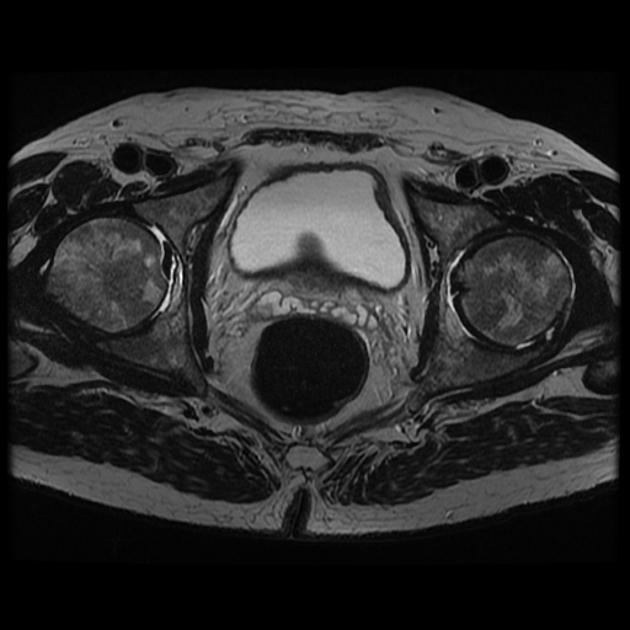

Image enregistrée : reference.png



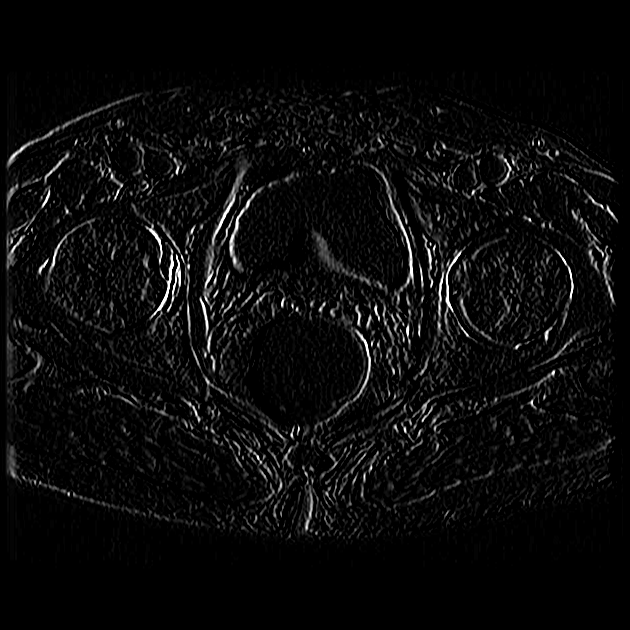

Algorithme génétique configuré.


In [4]:
// Charger une image de test
var imagePath = @"E:\Dev\AI\Cours\CoursIA\MyIA.AI.Notebooks\Search\MRI_Prostate_Cancer.jpg"; // Remplacez par un chemin valide
var originalImage = (Bitmap)Bitmap.FromFile(imagePath);

// await SkiaUtils.ShowImage(imagePath, originalImage.Width, originalImage.Height);

var fitness = new EdgeFitness(originalImage);
await fitness.DisplayImagesAsync();
var chromosome = new EdgeChromosome(20); // Taille des chromosomes
var population = new Population(50, 100, chromosome);

var selection = new EliteSelection();
var crossover = new UniformCrossover();
var mutation = new ReverseSequenceMutation();
var ga = new GeneticAlgorithm(population, fitness, selection, crossover, mutation)
{
    Termination = new GenerationNumberTermination(100)
};

Console.WriteLine("Algorithme génétique configuré.");


## Étape 4 : Exécution et Visualisation

Nous lançons l'algorithme génétique et suivons l'évolution des solutions.

---



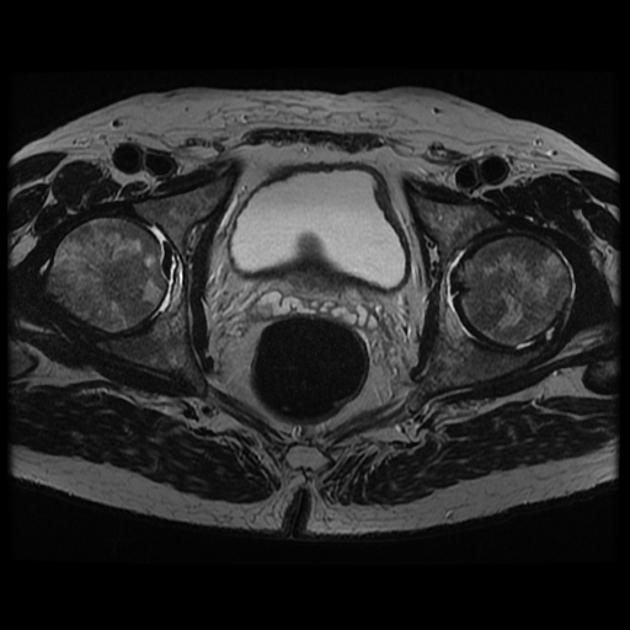

Lancement de l'algorithme génétique...
Génération 1 - Meilleur score : 1,0142693298470673
Génération 2 - Meilleur score : 1,6334703329573426
Génération 3 - Meilleur score : 1,6334703329573426
Génération 4 - Meilleur score : 1,6334703329573426
Génération 5 - Meilleur score : 1,6334703329573426
Génération 6 - Meilleur score : 1,87628169649733
Génération 7 - Meilleur score : 1,87628169649733
Génération 8 - Meilleur score : 1,87628169649733
Génération 9 - Meilleur score : 1,87628169649733
Génération 10 - Meilleur score : 1,87628169649733
Noyau généré :
-4 -5 -1 7 0 2 0 
-4 2 0 1 3 2 0 
0 0 -4 -2 8 0 0 
0 -3 -10 4 1 -3 3 
-9 0 1 -1 -1 -2 2 
1 1 3 2 -3 0 -4 
1 0 1 1 4 2 5 
Image enregistrée : best_generation_11.png
Image sauvegardée : best_generation_11.png



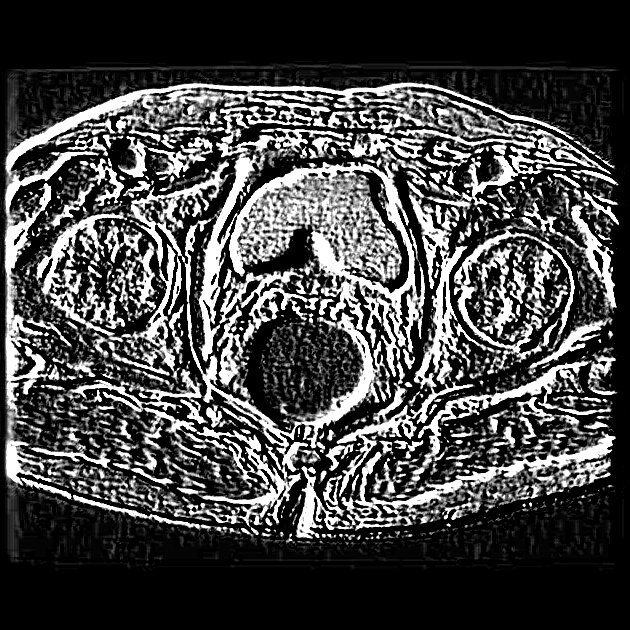

Génération 11 - Meilleur score : 2,127948417872115
Génération 12 - Meilleur score : 2,127948417872115
Génération 13 - Meilleur score : 2,127948417872115
Génération 14 - Meilleur score : 2,127948417872115
Génération 15 - Meilleur score : 2,127948417872115
Génération 16 - Meilleur score : 2,127948417872115
Génération 17 - Meilleur score : 2,127948417872115
Génération 18 - Meilleur score : 2,127948417872115
Génération 19 - Meilleur score : 2,127948417872115
Génération 20 - Meilleur score : 2,233073802406626
Noyau généré :
5 -1 -3 4 0 0 -1 
-1 -2 -5 -2 2 3 2 
4 0 -1 2 0 0 0 
1 0 -10 1 -2 -4 4 
-6 0 1 4 3 -1 6 
0 0 -1 2 -1 -2 -6 
-1 -2 2 -2 1 5 1 
Image enregistrée : best_generation_20.png
Image sauvegardée : best_generation_20.png



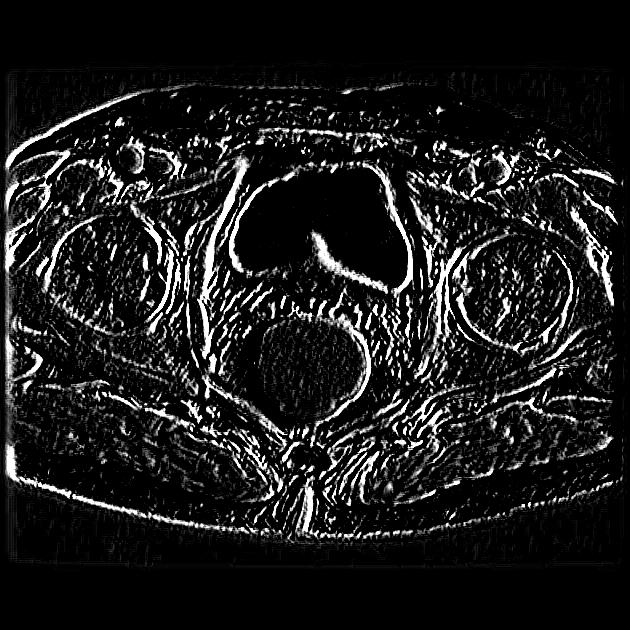

Génération 21 - Meilleur score : 2,236948312275293
Génération 22 - Meilleur score : 2,236948312275293
Génération 23 - Meilleur score : 2,236948312275293
Génération 24 - Meilleur score : 2,236948312275293
Génération 25 - Meilleur score : 2,236948312275293
Génération 26 - Meilleur score : 2,236948312275293
Génération 27 - Meilleur score : 2,236948312275293
Génération 28 - Meilleur score : 2,236948312275293
Génération 29 - Meilleur score : 2,236948312275293
Génération 30 - Meilleur score : 2,236948312275293
Noyau généré :
1 -5 -5 7 0 1 0 
-6 0 -4 -1 0 7 2 
3 -4 1 2 4 1 0 
1 -2 -9 1 -2 -5 5 
-10 2 -2 7 4 0 6 
-1 0 0 2 -2 0 -4 
3 0 -1 -5 1 6 0 
Image enregistrée : best_generation_30.png
Image sauvegardée : best_generation_30.png



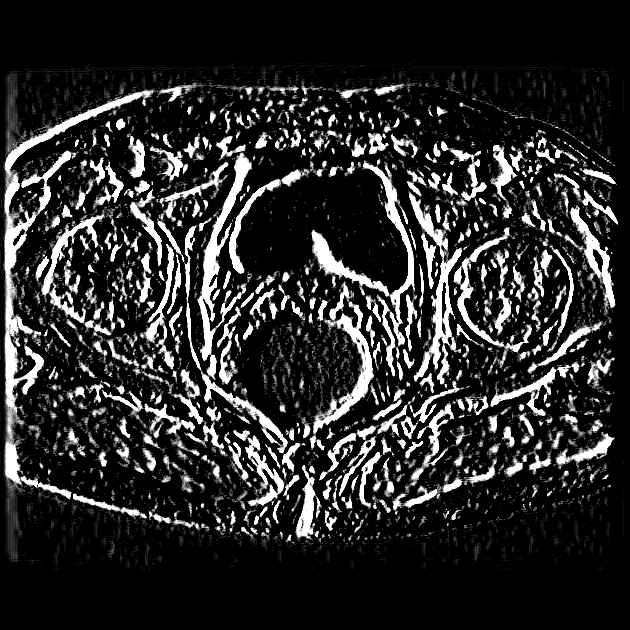

Génération 31 - Meilleur score : 2,2598199590429466
Génération 32 - Meilleur score : 2,2598199590429466
Génération 33 - Meilleur score : 2,2598199590429466
Génération 34 - Meilleur score : 2,3216948995539304
Génération 35 - Meilleur score : 2,3216948995539304
Génération 36 - Meilleur score : 2,3216948995539304
Génération 37 - Meilleur score : 2,3216948995539304
Génération 38 - Meilleur score : 2,3216948995539304
Génération 39 - Meilleur score : 2,3216948995539304
Génération 40 - Meilleur score : 2,3216948995539304
Noyau généré :
3 -5 -4 7 0 0 -2 
0 2 -6 -4 6 6 0 
3 0 -1 0 5 -1 0 
1 0 -10 0 0 1 2 
-6 -2 0 2 2 -2 8 
3 -2 -4 1 -1 0 -7 
3 -1 -3 -4 0 9 0 
Image enregistrée : best_generation_40.png
Image sauvegardée : best_generation_40.png



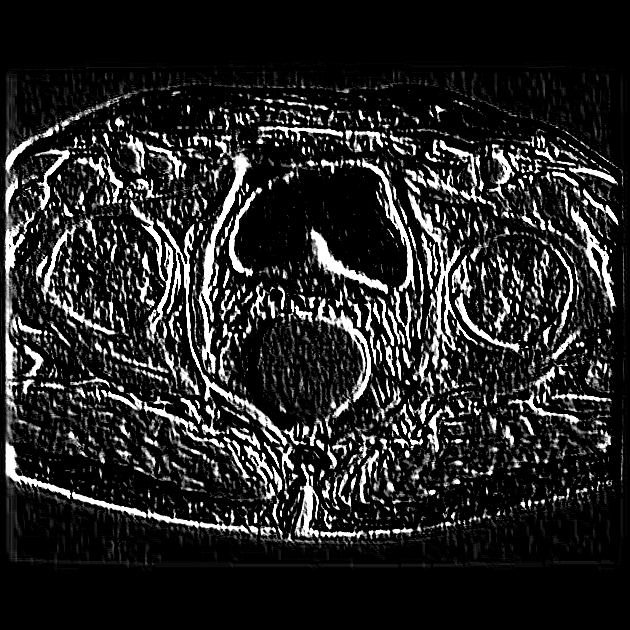

Génération 41 - Meilleur score : 2,4036353976124762
Génération 42 - Meilleur score : 2,4036353976124762
Génération 43 - Meilleur score : 2,4036353976124762
Génération 44 - Meilleur score : 2,448525499047207
Génération 45 - Meilleur score : 2,448525499047207
Génération 46 - Meilleur score : 2,448525499047207
Génération 47 - Meilleur score : 2,448525499047207
Génération 48 - Meilleur score : 2,4553967743933
Génération 49 - Meilleur score : 2,4553967743933
Génération 50 - Meilleur score : 2,4553967743933
Noyau généré :
2 -5 -4 7 0 0 -3 
-1 2 -6 -4 5 7 0 
4 0 -2 -1 6 0 0 
1 0 -10 0 0 0 3 
-8 -2 0 3 3 -2 8 
3 -2 -3 1 -1 1 -7 
3 0 -3 -4 0 9 -1 
Image enregistrée : best_generation_50.png
Image sauvegardée : best_generation_50.png



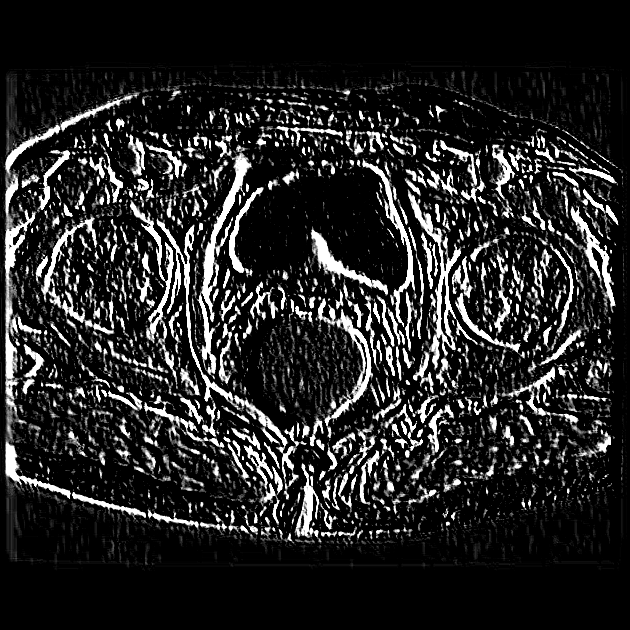

Génération 51 - Meilleur score : 2,4553967743933
Génération 52 - Meilleur score : 2,4553967743933
Génération 53 - Meilleur score : 2,4553967743933
Génération 54 - Meilleur score : 2,4553967743933
Génération 55 - Meilleur score : 2,4553967743933
Génération 56 - Meilleur score : 2,4553967743933
Génération 57 - Meilleur score : 2,4553967743933
Génération 58 - Meilleur score : 2,4553967743933
Génération 59 - Meilleur score : 2,4553967743933
Génération 60 - Meilleur score : 2,4553967743933
Noyau généré :
2 -5 -4 7 0 0 -3 
-1 2 -6 -4 5 7 0 
4 0 -2 -1 6 0 0 
1 0 -10 0 0 0 3 
-8 -2 0 3 3 -2 8 
3 -2 -3 1 -1 1 -7 
3 0 -3 -4 0 9 -1 
Image enregistrée : best_generation_60.png
Image sauvegardée : best_generation_60.png



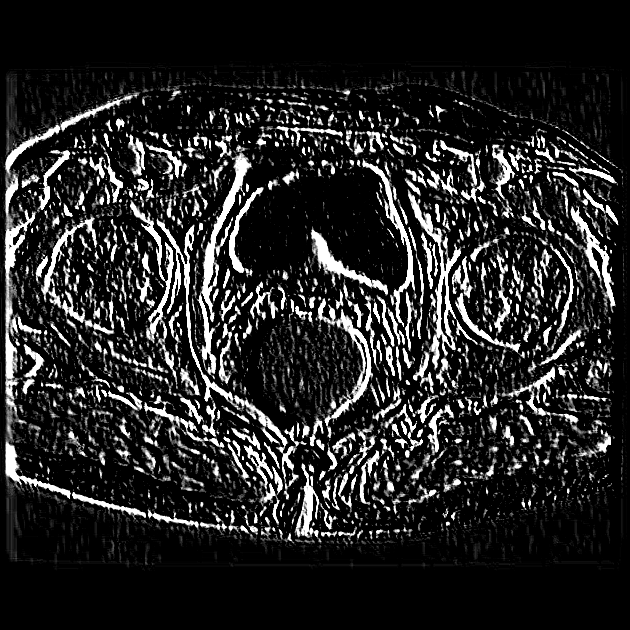

Génération 61 - Meilleur score : 2,4553967743933
Génération 62 - Meilleur score : 2,4553967743933
Génération 63 - Meilleur score : 2,4553967743933
Génération 64 - Meilleur score : 2,4553967743933
Génération 65 - Meilleur score : 2,4553967743933
Génération 66 - Meilleur score : 2,4553967743933
Génération 67 - Meilleur score : 2,4553967743933
Génération 68 - Meilleur score : 2,4553967743933
Génération 69 - Meilleur score : 2,4553967743933
Génération 70 - Meilleur score : 2,4553967743933
Noyau généré :
2 -5 -4 7 0 0 -3 
-1 2 -6 -4 5 7 0 
4 0 -2 -1 6 0 0 
1 0 -10 0 0 0 3 
-8 -2 0 3 3 -2 8 
3 -2 -3 1 -1 1 -7 
3 0 -3 -4 0 9 -1 
Image enregistrée : best_generation_70.png
Image sauvegardée : best_generation_70.png



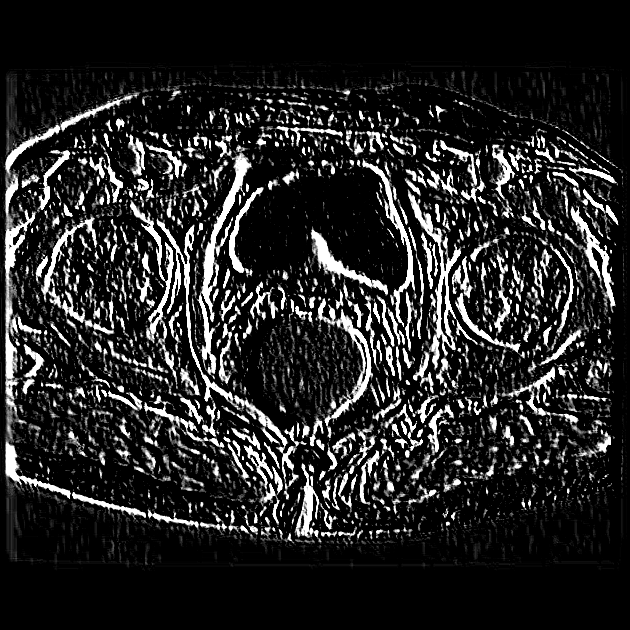

Génération 71 - Meilleur score : 2,4553967743933
Génération 72 - Meilleur score : 2,4553967743933
Génération 73 - Meilleur score : 2,4647888175816863
Génération 74 - Meilleur score : 2,4647888175816863
Génération 75 - Meilleur score : 2,4647888175816863
Génération 76 - Meilleur score : 2,493042366063375
Génération 77 - Meilleur score : 2,493042366063375
Génération 78 - Meilleur score : 2,493042366063375
Génération 79 - Meilleur score : 2,4931871057768866
Génération 80 - Meilleur score : 2,4931871057768866
Noyau généré :
2 -5 -5 8 -1 0 -2 
-2 1 -6 -4 4 7 1 
4 1 -2 -1 5 0 0 
1 0 -9 0 -1 -1 3 
-7 -2 0 3 5 -1 7 
2 -2 -2 2 0 0 -6 
3 0 -2 -5 -1 10 -3 
Image enregistrée : best_generation_80.png
Image sauvegardée : best_generation_80.png



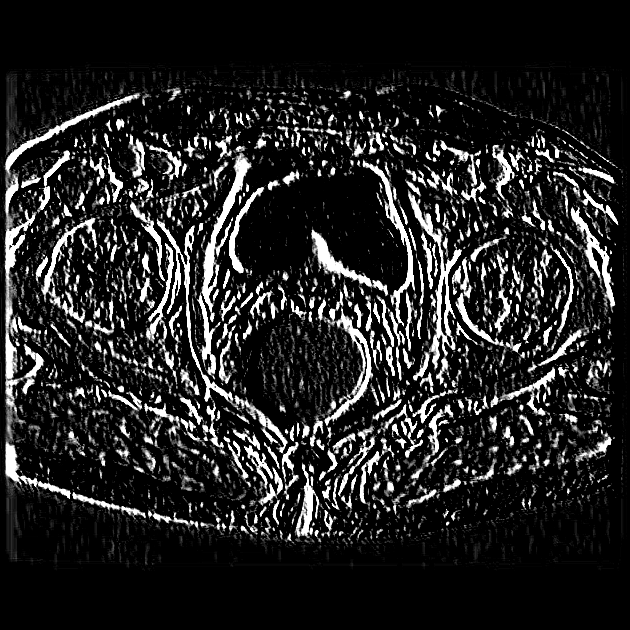

Génération 81 - Meilleur score : 2,533681555173371
Génération 82 - Meilleur score : 2,533681555173371
Génération 83 - Meilleur score : 2,533681555173371
Génération 84 - Meilleur score : 2,533681555173371
Génération 85 - Meilleur score : 2,533681555173371
Génération 86 - Meilleur score : 2,533681555173371
Génération 87 - Meilleur score : 2,533681555173371
Génération 88 - Meilleur score : 2,533681555173371
Génération 89 - Meilleur score : 2,533681555173371
Génération 90 - Meilleur score : 2,533681555173371
Noyau généré :
2 -3 -5 6 0 0 -4 
0 1 -7 -4 6 6 1 
5 1 -3 -2 5 0 -1 
3 0 -8 0 0 0 2 
-8 -1 0 1 4 -1 6 
2 -1 -2 0 0 0 -5 
1 0 0 -3 -1 10 -4 
Image enregistrée : best_generation_90.png
Image sauvegardée : best_generation_90.png



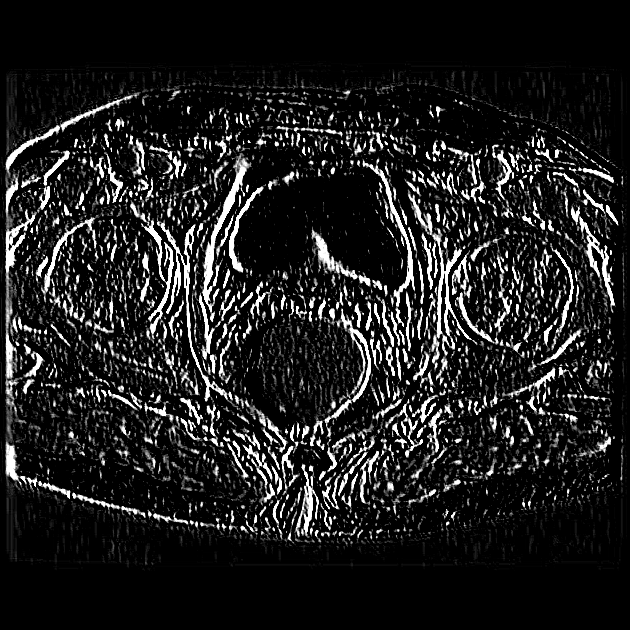

Génération 91 - Meilleur score : 2,533681555173371
Génération 92 - Meilleur score : 2,629988509310252
Génération 93 - Meilleur score : 2,629988509310252
Génération 94 - Meilleur score : 2,629988509310252
Génération 95 - Meilleur score : 2,629988509310252
Génération 96 - Meilleur score : 2,629988509310252
Génération 97 - Meilleur score : 2,629988509310252
Génération 98 - Meilleur score : 2,629988509310252
Génération 99 - Meilleur score : 2,629988509310252
Génération 100 - Meilleur score : 2,629988509310252
Meilleure solution trouvée avec un score de 2,629988509310252.
Noyau généré :
4 -4 -3 7 -3 0 -3 
-3 0 -7 -4 4 7 0 
4 3 -2 -1 5 0 -3 
1 -1 -8 0 0 -1 4 
-6 -2 0 2 6 -3 8 
3 -2 1 2 0 2 -5 
1 2 -3 -4 

In [5]:
// Initialiser le placeholder avec l'image originale
DisplayedValue imagePlaceholder = await SkiaUtils.ShowImage(imagePath, originalImage.Width, originalImage.Height);

ga.GenerationRan += (sender, e) =>
{
    var bestChromosome = ga.BestChromosome as EdgeChromosome;
    if (bestChromosome != null)
    {
        Console.WriteLine($"Génération {ga.GenerationsNumber} - Meilleur score : {bestChromosome.Fitness}");

        if (ga.GenerationsNumber % 10 == 0)
        {
            // Mettre à jour l'image via DisplayChromosomeResult
            Task.Run(async () =>
            {
                try
                {
                    imagePlaceholder = await fitness.DisplayChromosomeResult(bestChromosome, "best", ga.GenerationsNumber).ConfigureAwait(false);
                }
                catch (Exception ex)
                {
                    Console.WriteLine($"Erreur lors de la mise à jour de l'image : {ex.Message}");
                }
            });
        }
    }
};



Console.WriteLine("Lancement de l'algorithme génétique...");
ga.Start();
Console.WriteLine($"Meilleure solution trouvée avec un score de {ga.BestChromosome.Fitness}.");


## Conclusion

Ce TP vous a permis de découvrir les algorithmes génétiques appliqués à un problème de traitement d'images. Vous pouvez prolonger cette activité en modifiant les paramètres du GA ou en testant d'autres types de filtres de convolution.

---

**Prochaine étape :** Implémenter une version équivalente en Python avec PyGad !
